In [248]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statistics
import matplotlib.style as style

In [249]:
style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

In [283]:
monthly_sentiment_series = pd.read_csv('Dataset/SP500.csv',
                                     index_col=0, parse_dates=True,
                                     squeeze=True)

monthly_sentiment_series = monthly_sentiment_series.drop(columns = ['Open',
                                                  'High',
                                                  'Low',
                                                  'Close',
                                                  'Volume'])
#squeeze option will return a series
df_full = monthly_sentiment_series
#print(df_full.tail())
#print('type(df): ', type(df_full.index))
#print('df.dtypes: ', df_full.dtypes)
print('df.describe() \r\n', df_full.describe())
df_train = df_full.iloc[0:1100].rename(columns={0:'Date', 'Adj Close':'SP500'})
df_test = df_full.iloc[1100:].rename(columns={0:'Date', 'Adj Close':'SP500'})
#print('df.describe() \r\n', df_train.describe())
display(df_train)

df.describe() 
          Adj Close
count  1296.000000
mean   2477.317267
std     379.878172
min    1829.079956
25%    2104.147461
50%    2447.859986
75%    2791.734986
max    3386.149902


,SP500
Date,
2015-01-02,2058.199951
2015-01-05,2020.579956
2015-01-06,2002.609985
2015-01-07,2025.900024
2015-01-08,2062.139893
...,...
2019-05-10,2881.399902
2019-05-13,2811.870117
2019-05-14,2834.409912


Autoregressive - forecast next timestamp's values by regressing over previous values
AUTOREGRESSIVE - CORRELATION DECREASES AS N INCREASES

Moving average - forecast next timestamp's values based on previous errors values 
Moving average - calculates how much the time series is MOVING AWAY FROM THE AVERAGE.
MOVING AVERAGE - COVARIANCE IS ZERO

ARIMA - useful for non-stationary data, allows us to difference the data. Also includes seasonal differencing parameter for non-stationary data

In [562]:
df_train_diff1 = df_train.diff().fillna(0)
df_train_diff2 = df_train_diff1.diff().fillna(0)
print(df_train.tail())

                  SP500
Date                   
2019-05-10  2881.399902
2019-05-13  2811.870117
2019-05-14  2834.409912
2019-05-15  2850.959961
2019-05-16  2876.320068


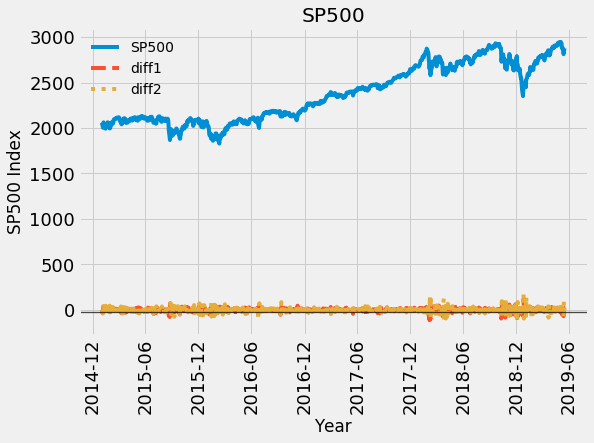

In [563]:
style.use('fivethirtyeight')
fig, ax= plt.subplots(figsize=(8,5))
fig.tight_layout()
ax.plot(df_train, label='SP500')
ax.plot(df_train_diff1, linestyle='dashed', label='diff1')
ax.plot(df_train_diff2, linestyle='dotted', label='diff2')
ax.legend(loc='best', frameon=False)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.axhline(y = -20, color = 'black', linewidth = 1.3, alpha = .7)
ax.set_ylabel('SP500 Index')
ax.set_xlabel('Year')
plt.title('SP500')
plt.xticks(rotation=90)
plt.show()

## look at ACF and PACF plots

ACF and PACF charts will give us an idea of the number of terms in the ARIMA model.

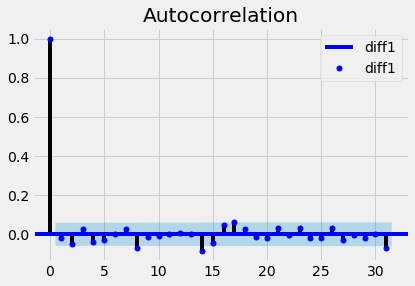

In [606]:
plot_acf(df_train_diff1, c='blue', label='diff1')
plt.legend(loc='upper right')
# plot_acf(df_train_diff2, c='blue', label='diff2')
# plt.legend(loc='upper right')
plt.show()

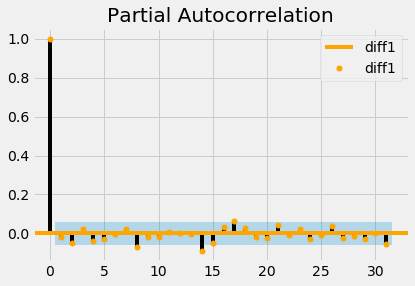

In [565]:
plot_pacf(df_train_diff1, c='orange', label='diff1')
plt.legend(loc='upper right')
# plot_pacf(df_train_diff2,  label='diff2')
# plt.legend(loc='upper right')
plt.show()


In [561]:
# blue area - 95% confidence interval. anything outside blue area --> significant correlation.
# any significant spike in lag x in ACF plot --> number of moving average terms.
# any significant spike in lag x in PACF plot --> number of autoregressive terms.

In [595]:
ARIMA_model=ARIMA(df_train_diff1, order=(5, 0, 3)).fit()
#Transparams = True means stationary. 
print(ARIMA_model.summary())

/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  SP500   No. Observations:                 1100
Model:                     ARMA(5, 3)   Log Likelihood               -4857.779
Method:                       css-mle   S.D. of innovations             20.028
Date:                Fri, 06 Mar 2020   AIC                           9735.558
Time:                        17:16:01   BIC                           9785.588
Sample:                             0   HQIC                          9754.484
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7586      0.281      2.695      0.007       0.207       1.310
ar.L1.SP500     0.3987      0.119      3.339      0.001       0.165       0.633
ar.L2.SP500    -0.3478      0.225     -1.545    

In [596]:
index_row_values = df_train.index
date_list = list(index_row_values)
print(date_list[0])
print(date_list[-1])

2015-01-02 00:00:00
2019-05-16 00:00:00


In [599]:
ARIMA_forecast = ARIMA_model.predict(1099, 1295, dynamic=True)
print('forecasted predictions\n',ARIMA_forecast)

forecasted predictions
 1099   -1.619795
1100    2.549036
1101    1.281984
1102   -1.710711
1103    1.666848
          ...   
1291    0.758241
1292    0.758336
1293    0.758375
1294    0.758287
1295    0.758325
Length: 197, dtype: float64


/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [570]:
## Transform the differenced X-scale back to original time scale

In [600]:
x=df_train.iloc[1098,0]
x

2850.959961

In [601]:
undiff_train_1 = ARIMA_forecast.cumsum() + x
# undiff_train_2 = undiff_train_1.cumsum()
#print(undiff_train_2.tail(12))
#undiff1 = arima.cumsum().fillna(df_diff1)
print(all(round(df_train, 6)==round(undiff_train_2, 6)))
print('Original Values', df_train.SP500.tail())
print('De-Differenced Values', undiff_train_1.tail())

True
Original Values Date
2019-05-10    2881.399902
2019-05-13    2811.870117
2019-05-14    2834.409912
2019-05-15    2850.959961
2019-05-16    2876.320068
Name: SP500, dtype: float64
De-Differenced Values 1291    2994.436440
1292    2995.194775
1293    2995.953150
1294    2996.711437
1295    2997.469762
dtype: float64


In [602]:
predicted_value_series = pd.DataFrame([df_full.index[1099:], undiff_train_1]).transpose()
predicted_value_series=predicted_value_series.rename(columns={0:'Date', 1:'SP500'})
predicted_value_series=predicted_value_series.set_index('Date')
predicted_value_series

,SP500
Date,
2019-05-16,2849.34
2019-05-17,2851.89
2019-05-20,2853.17
2019-05-21,2851.46
2019-05-22,2853.13
...,...
2020-02-20,2994.44
2020-02-21,2995.19
2020-02-24,2995.95


In [603]:
display(df_train.iloc[:,0:1099])
display(predicted_value_series)
df_full_predicted = df_train.iloc[:,0:1099].append(predicted_value_series)
df_full_predicted

,SP500
Date,
2015-01-02,2058.199951
2015-01-05,2020.579956
2015-01-06,2002.609985
2015-01-07,2025.900024
2015-01-08,2062.139893
...,...
2019-05-10,2881.399902
2019-05-13,2811.870117
2019-05-14,2834.409912


,SP500
Date,
2019-05-16,2849.34
2019-05-17,2851.89
2019-05-20,2853.17
2019-05-21,2851.46
2019-05-22,2853.13
...,...
2020-02-20,2994.44
2020-02-21,2995.19
2020-02-24,2995.95


,SP500
Date,
2015-01-02,2058.2
2015-01-05,2020.58
2015-01-06,2002.61
2015-01-07,2025.9
2015-01-08,2062.14
...,...
2020-02-20,2994.44
2020-02-21,2995.19
2020-02-24,2995.95


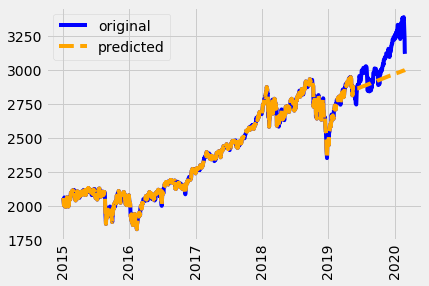

In [604]:
import numpy as np
style.use('fivethirtyeight')
plt.plot(df_full, c='blue', label='original')
plt.plot(df_full_predicted, linestyle='dashed', c='orange', label='predicted')
plt.xticks(rotation=90);
plt.legend(loc='best', facecolor='none')
plt.show()

In [605]:
MAE = np.mean(abs(df_test.SP500 - predicted_value_series))
print(mean_abs_error)

0.4116515999622834


In [540]:
test_results = adfuller(df_test.iloc[:,0], autolag='AIC')
print('p-value', test_results[1])

p-value 0.5824852551395194


In [62]:
# p-value of < 0.05 indicates that the data is stationary ? check on this.

In [415]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.xticks(rotation=90)
    plt.show(block=False);

Test Statistic           -1.399564
p-value                   0.582485
Lags Used                 0.000000
Observations Used       195.000000
Critical Value (1%)      -3.464337
Critical Value (5%)      -2.876479
Critical Value (10%)     -2.574733
dtype: float64


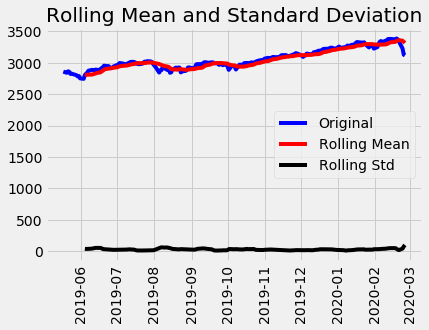

In [416]:
dftest(df_test.SP500)